In [2]:
from __future__ import print_function
#import potrebnih biblioteka
%matplotlib inline
import cv2
import numpy as np 
import matplotlib.pyplot as plt 
import collections

# keras
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.optimizers import SGD


import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 12 # za prikaz većih slika i plotova, zakomentarisati ako nije potrebno

C:\Users\Veljko\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
def image_bin(image_gs):
    height, width = image_gs.shape[0:2]
    image_binary = np.ndarray((height, width), dtype=np.uint8)
    ret,image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin
def invert(image):
    return 255-image
def display_image(image, color= False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')
def dilate(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)
def erode(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)

In [4]:
def resize_region(region):
    '''Transformisati selektovani region na sliku dimenzija 28x28'''
    return cv2.resize(region,(28,28), interpolation = cv2.INTER_NEAREST)

In [5]:
def select_roi(image_orig, image_bin):
    '''Oznaciti regione od interesa na originalnoj slici. (ROI = regions of interest)
        Za svaki region napraviti posebnu sliku dimenzija 28 x 28. 
        Za označavanje regiona koristiti metodu cv2.boundingRect(contour).
        Kao povratnu vrednost vratiti originalnu sliku na kojoj su obeleženi regioni
        i niz slika koje predstavljaju regione sortirane po rastućoj vrednosti x ose
    '''
    img, contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    sorted_regions = [] # lista sortiranih regiona po x osi (sa leva na desno)
    regions_array = []
    for contour in contours: 
        x,y,w,h = cv2.boundingRect(contour) #koordinate i velicina granicnog pravougaonika
        area = cv2.contourArea(contour)
        if area > 100 and h < 100 and h > 15 and w > 20:
            # kopirati [y:y+h+1, x:x+w+1] sa binarne slike i smestiti u novu sliku
            # označiti region pravougaonikom na originalnoj slici (image_orig) sa rectangle funkcijom
            region = image_bin[y:y+h+1,x:x+w+1]
            regions_array.append([resize_region(region), (x,y,w,h)])       
            cv2.rectangle(image_orig,(x,y),(x+w,y+h),(0,255,0),2)
    regions_array = sorted(regions_array, key=lambda item: item[1][0])
    sorted_regions = sorted_regions = [region[0] for region in regions_array]
    
    # sortirati sve regione po x osi (sa leva na desno) i smestiti u promenljivu sorted_regions
    return image_orig, sorted_regions

In [6]:
def scale_to_range(image): # skalira elemente slike na opseg od 0 do 1
    ''' Elementi matrice image su vrednosti 0 ili 255. 
        Potrebno je skalirati sve elemente matrica na opseg od 0 do 1
    '''
    return image/255

In [7]:
def matrix_to_vector(image):
    '''Sliku koja je zapravo matrica 28x28 transformisati u vektor sa 784 elementa'''
    return image.flatten()

In [8]:
def prepare_for_ann(regions):
    '''Regioni su matrice dimenzija 28x28 čiji su elementi vrednosti 0 ili 255.
        Potrebno je skalirati elemente regiona na [0,1] i transformisati ga u vektor od 784 elementa '''
    ready_for_ann = []
    for region in regions:
        # skalirati elemente regiona 
        # region sa skaliranim elementima pretvoriti u vektor
        # vektor dodati u listu spremnih regiona
        scale = scale_to_range(region)
        ready_for_ann.append(matrix_to_vector(scale))
        
    return ready_for_ann

In [9]:
def convert_output(alphabet):
    '''Konvertovati alfabet u niz pogodan za obučavanje NM,
        odnosno niz čiji su svi elementi 0 osim elementa čiji je
        indeks jednak indeksu elementa iz alfabeta za koji formiramo niz.
        Primer prvi element iz alfabeta [1,0,0,0,0,0,0,0,0,0],
        za drugi [0,1,0,0,0,0,0,0,0,0] itd..
    '''
    nn_outputs = []
    for index in range(len(alphabet)):
        output = np.zeros(len(alphabet))
        output[index] = 1
        nn_outputs.append(output)
    return np.array(nn_outputs)

In [10]:
def create_ann():
    '''Implementacija veštačke neuronske mreže sa 784 neurona na uloznom sloju,
        128 neurona u skrivenom sloju i 10 neurona na izlazu. Aktivaciona funkcija je sigmoid.
    '''
    ann = Sequential()
    ann.add(Dense(128, input_dim=784, activation='sigmoid'))
    ann.add(Dense(10, activation='sigmoid'))
    return ann
    
def train_ann(ann, X_train, y_train):
    '''Obucavanje vestacke neuronske mreze'''
    X_train = np.array(X_train, np.float32) # dati ulazi
    y_train = np.array(y_train, np.float32) # zeljeni izlazi za date ulaze
   
    # definisanje parametra algoritma za obucavanje
    sgd = SGD(lr=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd)

    # obucavanje neuronske mreze
    ann.fit(X_train, y_train, epochs=2000, batch_size=1, verbose = 0, shuffle=False) 
      
    return ann

In [11]:
def winner(output): # output je vektor sa izlaza neuronske mreze
    '''pronaći i vratiti indeks neurona koji je najviše pobuđen'''
    return max(enumerate(output), key=lambda x: x[1])[0]

In [12]:
def display_result(outputs, alphabet):
    '''za svaki rezultat pronaći indeks pobedničkog
        regiona koji ujedno predstavlja i indeks u alfabetu.
        Dodati karakter iz alfabet u result'''
    result = []
    for output in outputs:
        result.append(alphabet[winner(output)])
    return result

BROJ REGIONA: 493


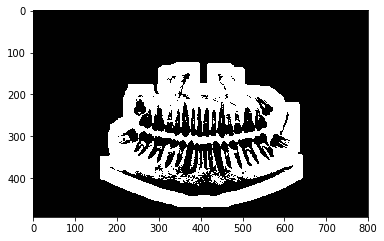

In [13]:
image_color = load_image('slika.jpg')
image_color = cv2.bitwise_not(image_color)
img_gray = image_gray(image_color)
ret, img_bin = cv2.threshold(img_gray, 140, 255, cv2.THRESH_BINARY)
ret1, img_bin1 = cv2.threshold(img_gray, 139, 255, cv2.THRESH_BINARY)
#ret, img_bin = cv2.threshold(img_gray, 0, 255, cv2.THRESH_OTSU)
#img_bin = image_bin(img_gray)
img = invert(img_bin)
img_bin = erode(dilate(img))
selected_regions, zubi = select_roi(image_color.copy(), img)
print("BROJ REGIONA: " + str(len(selected_regions)))
display_image(img_bin - img_bin1)

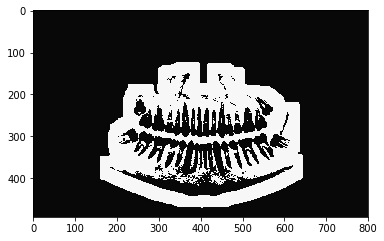

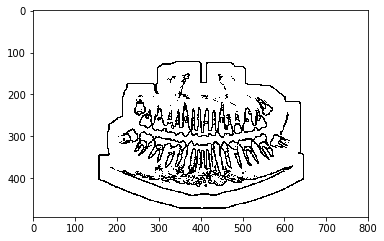

In [14]:
image_color = load_image('slika.jpg')
image_color = cv2.bitwise_not(image_color)
display_image(image_color)

image_color = image_gray(image_color)

height, width = image_color.shape[0:2]
x = range(0, 256)
y = np.zeros(256)
    
for i in range(0, height):
    for j in range(0, width):
        if(image_color[i,j] > 130):
            image_color[i, j] += 20
        else:
            image_color[i, j] -= 20
    
display_image(image_color)

img_bin = cv2.adaptiveThreshold(image_color, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 7, 7)
plt.figure() # ako je potrebno da se prikaze vise slika u jednoj celiji
plt.imshow(img_bin, 'gray')

In [15]:
zubi = [11,12,13,14,15,16,17,18,21,22,23,24,25,26,27,28,41,42,43,44,45,46,47,48,31,32,33,34,35,36,37,38]

In [20]:
inputs = prepare_for_ann(zubi)
outputs = convert_output(zubi)
ann = create_ann()
ann = train_ann(ann, inputs, outputs)

AttributeError: 'float' object has no attribute 'flatten'

In [21]:
result = ann.predict(np.array(inputs[2:4], np.float32))
print(result)
#print(display_result(result, zubi))

NameError: name 'ann' is not defined

NameError: name 'ann' is not defined

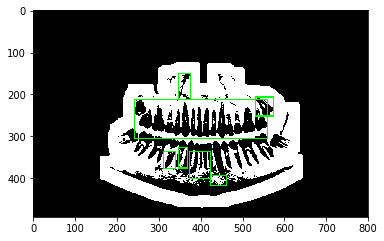

In [22]:
test_color = load_image('slika.jpg')
test = invert(image_bin(image_gray(test_color)))
test_bin = erode(dilate(test))
selected_test, test_numbers = select_roi(test_color.copy(),test_bin)
display_image(selected_test)
test_inputs = prepare_for_ann(test_numbers)
result = ann.predict(np.array(test_inputs, np.float32))
#print(display_result(result, zubi))
cv2.imwrite('ocr.jpg',dist2)